This notebook is the pytorch implementation of the following CNN for the classification of CIFAR10 dataset



In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter



Download and normalize the data into gaussian distribution

In [94]:
train_data = torchvision.datasets.CIFAR10("data/", train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(0, 1)]), download=False)

test_data = torchvision.datasets.CIFAR10("data/", train=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(0, 1)]), download=False)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=False)

trainiter = iter(train_data)
testiter = iter(test_data)


In [95]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        nn.init.xavier_uniform(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, padding=2)
        nn.init.xavier_uniform(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        nn.init.xavier_uniform(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*4*32, 128)
        nn.init.xavier_uniform(self.fc1.weight)
        self.fc2 = nn.Linear(128, 10)
        nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        return F.log_softmax(x, dim=1)
        





In [105]:
network = Net().cuda()
optimizer = torch.optim.Adam(network.parameters())




In [106]:
losses = []
accuracies = []
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(2 + 1)]

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()



In [107]:
def train(num_epoch):
  network.train()
  for epoch in range(num_epoch):
    for batch_idx, (data, target) in enumerate(trainloader):
        data = data.to("cuda")
        target = target.to("cuda")
        
        #clear the gradients attatched to the parameters
        optimizer.zero_grad()
        #forward propagation
        output = network(data)
        #negative log-likelihood loss(no built-in softmax)
        #cross-entropy applies softmax 
        loss = F.nll_loss(output, target)
        #backpropagation
        loss.backward()
        #gradient descent and weight update
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), 
            len(trainloader.dataset), 100. * batch_idx / len(trainloader), loss.item()))
            #loss.item() gives the value
            train_losses.append(loss.item())
            train_counter.append((batch_idx*200) + ((epoch-1)*len(trainloader.dataset)))
            writer.add_scalar("Train Iteration Loss", loss.item(), (batch_idx*200) + ((epoch-1)*len(trainloader.dataset)))



In [108]:
train(10)

Train Epoch: 0 [0/50000 (0%)]	Loss: 7.308592
Train Epoch: 0 [10000/50000 (20%)]	Loss: 3.765698
Train Epoch: 0 [20000/50000 (40%)]	Loss: 3.577904
Train Epoch: 0 [30000/50000 (60%)]	Loss: 3.457823
Train Epoch: 0 [40000/50000 (80%)]	Loss: 3.652019
Train Epoch: 1 [0/50000 (0%)]	Loss: 3.579952
Train Epoch: 1 [10000/50000 (20%)]	Loss: 3.401045
Train Epoch: 1 [20000/50000 (40%)]	Loss: 3.405954
Train Epoch: 1 [30000/50000 (60%)]	Loss: 3.419347
Train Epoch: 1 [40000/50000 (80%)]	Loss: 3.471840
Train Epoch: 2 [0/50000 (0%)]	Loss: 3.463866
Train Epoch: 2 [10000/50000 (20%)]	Loss: 3.109112
Train Epoch: 2 [20000/50000 (40%)]	Loss: 3.225302
Train Epoch: 2 [30000/50000 (60%)]	Loss: 3.411566
Train Epoch: 2 [40000/50000 (80%)]	Loss: 3.453755
Train Epoch: 3 [0/50000 (0%)]	Loss: 3.143711
Train Epoch: 3 [10000/50000 (20%)]	Loss: 3.584530
Train Epoch: 3 [20000/50000 (40%)]	Loss: 3.189338
Train Epoch: 3 [30000/50000 (60%)]	Loss: 3.078402
Train Epoch: 3 [40000/50000 (80%)]	Loss: 3.108449
Train Epoch: 4 [0/50

In [109]:
writer.add_graph(network)
writer.close()


TypeError: 'NoneType' object is not iterable

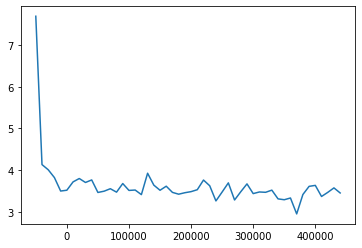

In [100]:
from matplotlib import pyplot as plt
plt.plot(train_counter, train_losses)
plt.show()

In [101]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  # deactivated autograd engine
  #notifies that we do not need to hold the gradients in the parameters
  #impacts memory utilization drastically during test
  with torch.no_grad():
    for data, target in testloader:
      data = data.to("cuda")
      target = target.to("cuda")
      output = network(data).to("cuda")
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))

In [102]:
test()


Test set: Avg. loss: 2.8622, Accuracy: 5730/10000 (57%)

